- Installation

In [1]:
# %pip install git+https://github.com/Louis-Li-dev/ML_tool_kit
# %pip install torch
# %pip install numpy
# %pip install matplotlib

- Resolve Paths

In [2]:

import os
import sys
BASE_DIR = os.getcwd()
parent_dir = os.path.join(BASE_DIR, '..')
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

- Import Packages

In [3]:
import torch
import torch.nn as nn
import numpy as np
from mkit.torch_support.nn_utils import training_loop
from mkit.torch_support.tensor_utils import xy_to_tensordataset, one_cut_split, sequential_x_y_split
from mkit.torch_support.predict import autoregressive
from mkit.torch_support.model.RNN import StackedResidualIndRNN
from mkit.torch_support.dummy_dataset import DummySequentialData
from mkit.preprocess.transform import MinMaxScaler
import matplotlib.pyplot as plt

- Generate Dummy Data

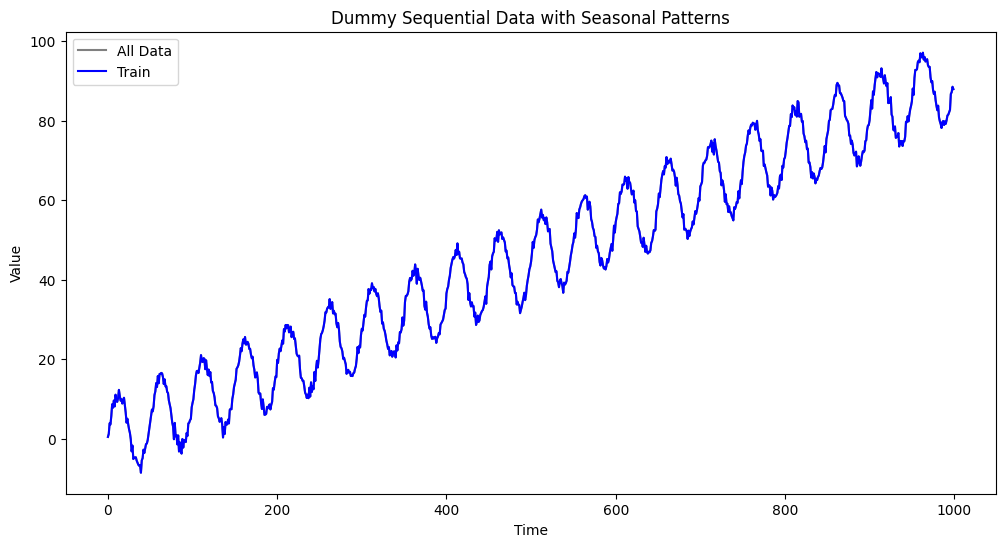

In [4]:
LOOK_BACK = 100
data = DummySequentialData(trend=.09)
transformer = MinMaxScaler()
data.plot_data()

- Data Transform and Preprocessing

In [5]:

train, val, test = one_cut_split(data.data, val_split=.2, test_split=.2)
train_transformed = transformer.fit_transform(train)
train_x, train_y = sequential_x_y_split(train_transformed, look_back=LOOK_BACK)
val_transformed = transformer.transform(val)
val_x, val_y = sequential_x_y_split(val_transformed, look_back=LOOK_BACK)

- Transform Types

In [6]:

train_loader = xy_to_tensordataset(
    train_x, train_y, 
    return_loader=True, 
    unsqueeze_last=True,
    input_dtype=torch.float,
    output_dtype=torch.float
)
val_loader = xy_to_tensordataset(
    val_x, 
    val_y, 
    return_loader=True, 
    unsqueeze_last=True # for regression task, the last dim needs to be one
) 

- Model Building

In [7]:


device = torch.device('cuda')
model = StackedResidualIndRNN(
    input_dim=1, 
    hidden_dims=[8, 16], 
    seq_len=LOOK_BACK,
    output_dim=1,
    device=device
)

- Training

In [8]:
model, train_losses, val_losses = training_loop(
    model=model,
    device=device,
    criterion=nn.MSELoss(),
    epochs=5,
    train_loader=train_loader,
    optimizer=torch.optim.Adam(model.parameters()),
    val_loader=val_loader,
    keep_losses=True,
)

EPOCH 1/5:   0%|          | 0/17 [00:00<?, ?it/s]c:\Users\ss348\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([32, 1, 1])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
EPOCH 1/5:  94%|█████████▍| 16/17 [00:14<00:00,  1.23it/s]c:\Users\ss348\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([28, 1, 1])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
EPOCH 1/5: 100%|██████████| 17/17 [00:15<00:00,  1.09it/s]


Epoch [1/5] Training Loss: 0.0445  Validation Loss: 0.2445



EPOCH 2/5: 100%|██████████| 17/17 [00:14<00:00,  1.14it/s]


Epoch [2/5] Training Loss: 0.0432  Validation Loss: 0.2053



EPOCH 3/5: 100%|██████████| 17/17 [00:08<00:00,  1.90it/s]


Epoch [3/5] Training Loss: 0.0432  Validation Loss: 0.1975



EPOCH 4/5: 100%|██████████| 17/17 [00:08<00:00,  1.96it/s]


Epoch [4/5] Training Loss: 0.0432  Validation Loss: 0.1853



EPOCH 5/5: 100%|██████████| 17/17 [00:08<00:00,  1.90it/s]


Epoch [5/5] Training Loss: 0.0431  Validation Loss: 0.2126

Training complete.


## Prediction and Evaluation

- Time-series Non-autoregressive

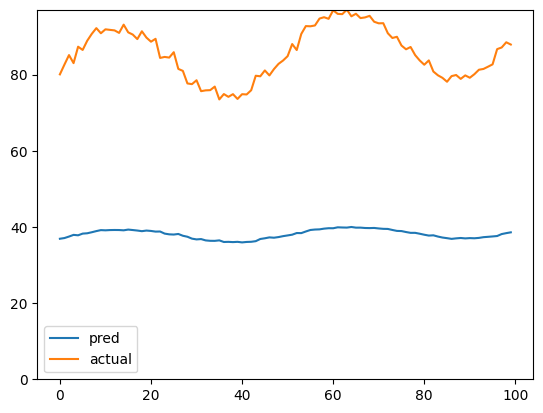

In [9]:


test_x, test_y = sequential_x_y_split(test, look_back=LOOK_BACK)
model.to(device)
with torch.no_grad():
    pred = model(torch.tensor(transformer.transform(test_x), dtype=torch.float, device=device).unsqueeze(-1)).detach().cpu()
    pred = transformer.inverse_transform(pred).detach().cpu().squeeze(-1).numpy()
plt.plot(pred, label='pred')
plt.plot(test_y.ravel(), label='actual')
plt.ylim(0, np.max([pred, test_y.ravel()]))
plt.legend()

- Autoregressive

In [10]:
result = autoregressive(
    x=train_x[-1], 
    model=model,
    steps_ahead=len(test), 
    device=torch.device('cpu')
)

100%|██████████| 200/200 [00:15<00:00, 12.57it/s]

Autoregressive Prediction Completed🚀


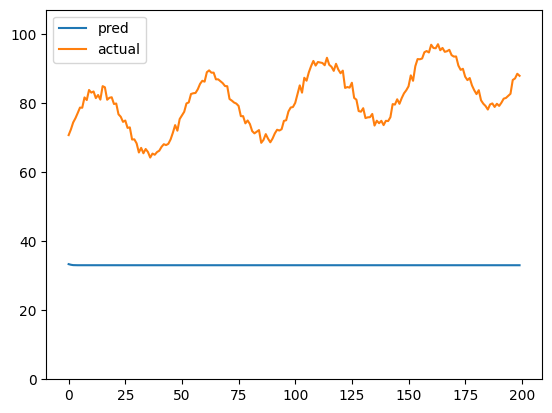

In [11]:
pred_a = transformer.inverse_transform(result.cpu().detach().numpy())
plt.ylim(0, np.max([pred_a, test]) + 10)
plt.plot(pred_a, label='pred')
plt.plot(test, label='actual')
plt.legend()
plt.show()